In [12]:
import pandas as pd
import numpy as np
import joblib
import os
import configparser as cp
from sqlalchemy import create_engine
import mysql.connector

from plotnine import *
os.getcwd()

'/home/ubuntu/projects/Stock_Price_Prediction'

In [2]:
config=cp.ConfigParser()
config.read('/home/ubuntu/certi/db_login.txt')
db_config=config['ivan_db']
engine=create_engine('mysql+mysqlconnector://{0:s}:{1:s}@{2:s}/{3:s}'.format(db_config['userid'],
                                                                             db_config['pwd'],
                                                                             db_config['hostname'],
                                                                             'STOCK_PRED'))

# Data Loading

df=pd.read_sql("""SELECT * 
                  FROM STOCK_PRED.ALL_STOCK_HIST 
                  WHERE DATE>=STR_TO_DATE('2020-01-01','%Y-%m-%d')
                  """,
              con=engine)
print(df.shape)
#joblib.dump(df,'/home/ubuntu/projects/Stock_Price_Prediction/data/stock_price_2020_2021.pkl')

In [10]:
df=joblib.load('/home/ubuntu/projects/Stock_Price_Prediction/data/stock_price_2020_2021.pkl')
print(df.shape)
print(df.REFRESH_DATE.min())
df.dtypes

(2141748, 9)
2021-08-15 00:00:00


Date            datetime64[ns]
Open                   float64
High                   float64
Low                    float64
Close                  float64
Volume                 float64
SE                      object
Stock                   object
REFRESH_DATE    datetime64[ns]
dtype: object

In [11]:
df.head(5)

,Date,Open,High,Low,Close,Volume,SE,Stock,REFRESH_DATE
0,2020-01-02,1.35,1.38,1.35,1.35,4300.0,NASDAQ,AACG,2021-08-15
1,2020-01-03,1.36,1.49,1.36,1.47,42000.0,NASDAQ,AACG,2021-08-15
2,2020-01-06,1.51,1.51,1.36,1.43,18700.0,NASDAQ,AACG,2021-08-15
3,2020-01-07,1.39,1.44,1.36,1.43,13700.0,NASDAQ,AACG,2021-08-15
4,2020-01-08,1.41,1.58,1.36,1.51,90900.0,NASDAQ,AACG,2021-08-15


## Checking

### NAs and Negative 

In [13]:
## NAs
pd.DataFrame({'vals':df.isnull().sum()}).loc[lambda x:x.vals>0]

,vals
Open,28
High,28
Low,28
Close,28
Volume,28


In [14]:
df.loc[df.Open.isnull(),:]

,Date,Open,High,Low,Close,Volume,SE,Stock,REFRESH_DATE
173008,2021-04-27,NaN,NaN,NaN,NaN,NaN,NASDAQ,BYRN,2021-08-15 00:00:00
184921,2021-08-02,NaN,NaN,NaN,NaN,NaN,NASDAQ,CBAN,2021-08-15 00:00:00
568978,2020-12-28,NaN,NaN,NaN,NaN,NaN,NASDAQ,KMPH,2021-08-15 00:00:00
606992,2021-08-02,NaN,NaN,NaN,NaN,NaN,NASDAQ,LMRK,2021-08-15 00:00:00
726841,2020-10-19,NaN,NaN,NaN,NaN,NaN,NASDAQ,NUWE,2021-08-15 00:00:00
1091882,2020-12-15,NaN,NaN,NaN,NaN,NaN,NASDAQ,VS,2021-08-15 00:00:00
1104711,2020-12-07,NaN,NaN,NaN,NaN,NaN,NASDAQ,WFCF,2021-08-15 00:00:00
1264735,2021-08-02,NaN,NaN,NaN,NaN,NaN,NYSE,BMO,2021-08-15 00:00:00
1291484,2021-08-02,NaN,NaN,NaN,NaN,NaN,NYSE,CAG,2021-08-15 00:00:00
1294414,2021-08-02,NaN,NaN,NaN,NaN,NaN,NYSE,CAPL,2021-08-15 00:00:00


In [15]:
## Negative
pd.DataFrame({'vals':df.select_dtypes(include=['float64']).apply(lambda x:(x<0).astype(int).sum())}).loc[lambda x:x.vals>0]

,vals
Open,304
High,304
Low,304
Close,304


In [20]:
df.loc[df.Open<0][:5]

,Date,Open,High,Low,Close,Volume,SE,Stock,REFRESH_DATE
1173045,2020-01-02,-4.621460,-4.629507,-4.501654,-4.522218,6605000.0,NYSE,AIV,2021-08-15
1173046,2020-01-03,-4.507019,-4.614308,-4.496290,-4.593744,8263300.0,NYSE,AIV,2021-08-15
1173047,2020-01-06,-4.586591,-4.635765,-4.556193,-4.622354,16151000.0,NYSE,AIV,2021-08-15
1173048,2020-01-07,-4.600896,-4.623248,-4.549934,-4.562451,11878100.0,NYSE,AIV,2021-08-15
1173049,2020-01-08,-4.566028,-4.608943,-4.559770,-4.583015,9504100.0,NYSE,AIV,2021-08-15


## Spot checking 

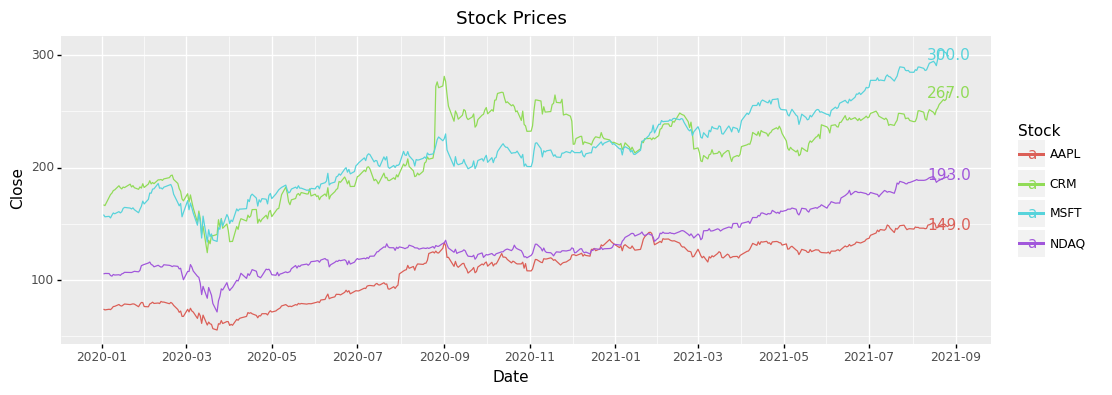

<ggplot: (8759665619188)>


In [73]:
df_temp=df.loc[df.Stock.isin(['CRM','MSFT','AAPL','NDAQ']),:]
print(
    ggplot(df_temp,
           aes('Date','Close',color='Stock'))
    +geom_line()
    +geom_text(aes(label='close_re'),
              df_temp.loc[df_temp.Date==df_temp.Date.max(),:].assign(close_re=lambda x:round(x.Close,0))
              )
    +scale_x_datetime(date_labels='%Y-%m')
    +theme(figure_size=(12,4))
    +labs(title='Stock Prices')
)
#print(
#    ggplot(df.loc[df.Stock=='MSFT',:],aes('Date','Close'))
#    +geom_line(color='orange')
#    +scale_x_datetime(date_labels='%Y-%m')
#    +theme(figure_size=(12,4))
#    +labs(title='MSFT')
#)


# Analysis 

## Correlation 

In [68]:
col=[]

for i in df.Stock.unique():
    msft=df.loc[df.Stock=='MSFT','Close'].reset_index(drop=True)
    if i=='MSFT':
        continue
    corr_coef=msft.corr(df.loc[df.Stock==i,'Close'].reset_index(drop=True))
    result={'Stock':i,
            'Close_corr':corr_coef}
    col.append(result)

/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide


In [74]:
pd.DataFrame(col).sort_values(by='Close_corr',ascending=False)[:20]

,Stock,Close_corr
4005,CRL,0.974112
1525,IDXX,0.970475
2115,NDAQ,0.969963
4226,EPAM,0.968185
4257,ETJ,0.966090
3465,ACN,0.965799
5862,VRT,0.965592
2200,NVDA,0.964919
2244,ODFL,0.964917
4145,DT,0.964521


In [56]:
msft.corr(df.loc[df.Stock=='CRM','Close'].reset_index(drop=True))

0.7729971667682901

In [54]:
df.loc[df.Stock=='CRM','Close']

1349052    166.990005
1349053    166.169998
1349054    173.449997
1349055    176.000000
1349056    177.330002
              ...    
2118110    260.519989
2118111    259.660004
2118112    260.850006
2118113    267.790009
2118114    266.529999
Name: Close, Length: 418, dtype: float64

In [ ]:
# Parallel with dask: https://github.com/dask/dask-tutorial/blob/main/01_dask.delayed.ipynb

In [78]:
from dask import delayed
from dask.distributed import Client
client=Client(n_workers=2)

/home/ubuntu/anaconda3/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45857 instead


In [82]:
def stock_correlate(benchmark_stock=None):
    if benchmark_stock==None:
        benchmark_stock='MSFT' 
    col=[]
    for i in df.Stock.unique():
        benchmark=df.loc[df.Stock==benchmark_stock,'Close'].reset_index(drop=True)
        if i==benchmark_stock:
            continue
        corr_coef=benchmark.corr(df.loc[df.Stock==i,'Close'].reset_index(drop=True))
        result={'Stock':i,
                'Close_corr':corr_coef}
        col.append(result)
    return col

In [ ]:
col=[]
for i in df.Stock.unique():
    benchmark=df.loc[df.Stock=='MSFT','Close'].reset_index(drop=True)
    if i=='MSFT':
        continue
    corr_coef=delayed(pd.Series.corr)(benchmark, 
                                      df.loc[df.Stock==i,'Close'].reset_index(drop=True))
    result={'Stock':i,
            'Close_corr':corr_coef}
    col.append(result)

total=delayed()(col)
total.compute()

In [83]:
result=delayed(stock_correlate).compute()

In [90]:
stock_correlate_2.compute()

AttributeError: 'function' object has no attribute 'compute'

In [86]:
pd.Series.corr(df.loc[df.Stock=='MSFT','Close'].reset_index(drop=True), df.loc[df.Stock=='CRM','Close'].reset_index(drop=True))

0.7729971667682901